<a href="https://colab.research.google.com/github/SilverJester/Walmart-Case-Study/blob/main/Walmart_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective of Case Study

To analyze the customer purchase behavior (specifically, purchase amount) against the customer’s gender,marital status and the various other factors to help the business make better decisions

# Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm,binom
import matplotlib.pyplot as plt
import seaborn as sns

# Reading the dataset

In [ ]:
path='/content/drive/MyDrive/Practice datasets /walmart_data.csv'
df=pd.read_csv(path)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969


In [ ]:
df.shape

(550068, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB


In [ ]:
df['Marital_Status']=df['Marital_Status'].apply(lambda x: 'Married' if x==1 else 'Not Married')

In [ ]:

for i in df.columns[:-1]:
  df[i]=df[i].astype('category')

In [ ]:
df.describe(include="category")

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category
count,550068,550068,550068,550068,550068,550068,550068,550068,550068
unique,5891,3631,2,7,21,3,5,2,20
top,1001680,P00265242,M,26-35,4,B,1,Not Married,5
freq,1026,1880,414259,219587,72308,231173,193821,324731,150933


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.describe()

,Purchase
count,550068.000000
mean,9263.968713
std,5023.065394
min,12.000000
25%,5823.000000
50%,8047.000000
75%,12054.000000
max,23961.000000


# Handeling Outliers

<Axes: ylabel='Purchase'>

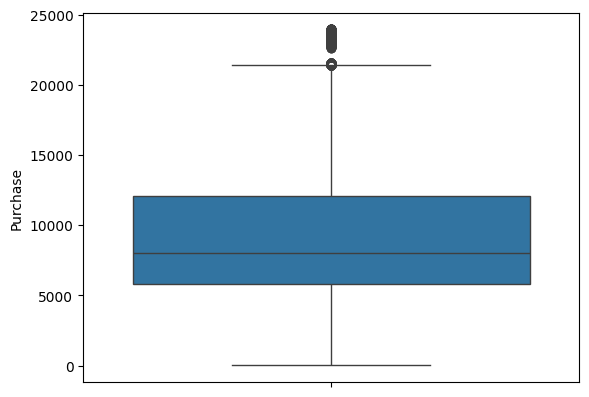

In [ ]:
sns.boxplot(df['Purchase'])

In [ ]:
Q1=df['Purchase'].quantile(0.25)
Q3=df['Purchase'].quantile(0.75)
IQR=Q3-Q1
upper_boundary=Q3+IQR*1.5
lower_boundary=Q1-IQR*1.5
df['Purchase']=np.clip(df['Purchase'],lower_boundary,upper_boundary)

#Visual Analysis

## Univariate Analysis

<Axes: xlabel='Purchase', ylabel='Count'>

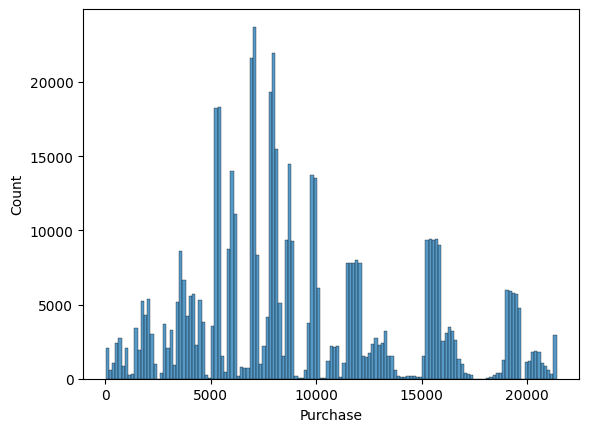

In [ ]:
sns.histplot(data=df,x='Purchase')

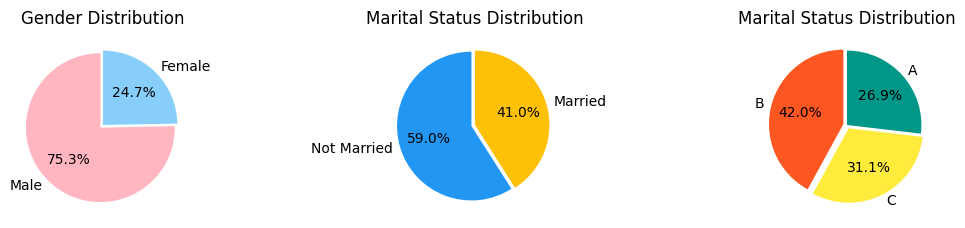

In [ ]:
gender_proportion=(df['Gender'].value_counts(normalize=True))*100
value_gender=gender_proportion.to_numpy()

marital_status_proportion=(df['Marital_Status'].value_counts(normalize=True))*100
value_marital_status=marital_status_proportion.to_numpy()

city_category_proportion=(df['City_Category'].value_counts(normalize=True))*100
value_city_category=city_category_proportion.to_numpy()
plt.figure(figsize=(12, 8))
plt.subplot(1,3,1)

plt.pie(value_gender,labels=['Male','Female'],explode=(0.05,0),colors=['#FFB6C1', '#87CEFA'],autopct='%1.1f%%',startangle=90)
plt.title("Gender Distribution")

plt.subplot(1,3,2)
plt.pie(value_marital_status,labels=['Not Married','Married'],explode=(0.05,0),colors=['#2196F3', '#FFC107'],autopct='%1.1f%%',startangle=90)
plt.title("Marital Status Distribution")

plt.subplot(1,3,3)
plt.pie(value_city_category,labels=['B','C','A'],explode=(0.05,0.05,0),colors=['#FF5722', '#FFEB3B','#009688'],autopct='%1.1f%%',startangle=90)
plt.title("Marital Status Distribution")

plt.subplots_adjust(wspace=1, hspace=0.5)


plt.show()


## Bivariate Analysis

<Axes: xlabel='Gender', ylabel='Purchase'>

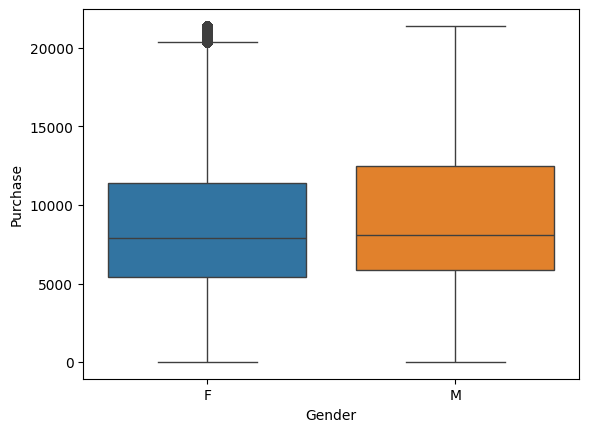

In [ ]:
sns.boxplot(data=df,x='Gender',y='Purchase',hue='Gender')

<Axes: xlabel='Age', ylabel='Purchase'>

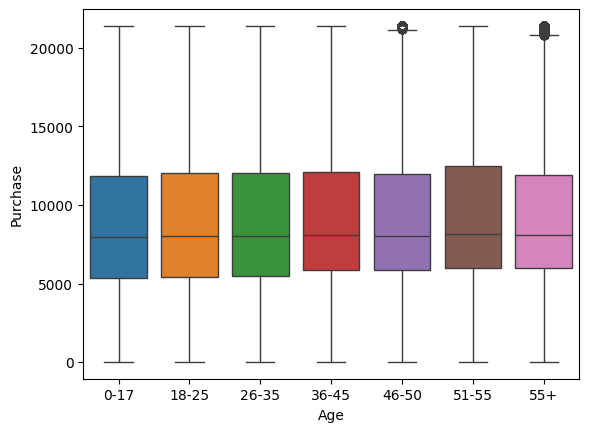

In [ ]:
sns.boxplot(data=df,x='Age',y='Purchase',hue='Age')

<Axes: xlabel='Marital_Status', ylabel='Purchase'>

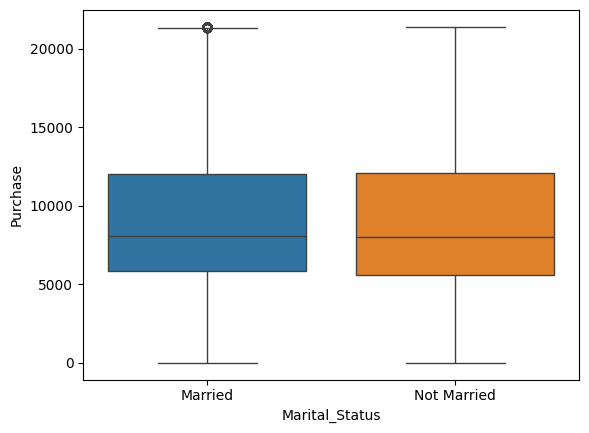

In [ ]:
sns.boxplot(data=df,x='Marital_Status',y='Purchase',hue='Marital_Status')

## Multivariate Analysis

<Axes: xlabel='Age', ylabel='Purchase'>

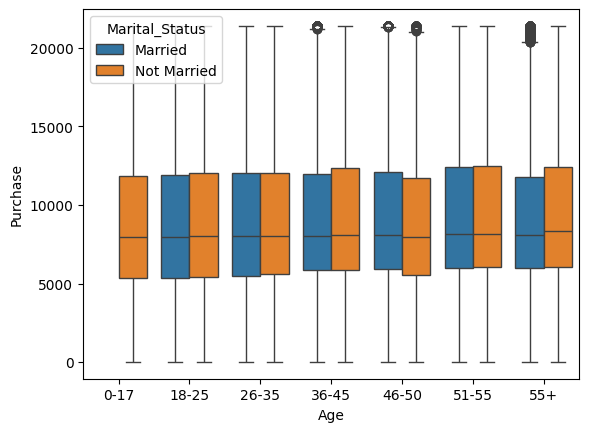

In [ ]:
sns.boxplot(x='Age', y='Purchase', hue='Marital_Status', data=df)

# Computing CLT

## How does Gender affect the amount spent?

In [ ]:
male_spending = df[df['Gender'] == 'M']['Purchase']
female_spending = df[df['Gender'] == 'F']['Purchase']

def compute_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    n = len(data)
    z_score = norm.ppf((1 + confidence) / 2)
    sem = std_dev / np.sqrt(n)
    margin_of_error = z_score * sem
    return mean, mean - margin_of_error, mean + margin_of_error


def bootstrap_confidence_intervals(data, sample_size, num_bootstraps=10000, confidence=0.95):
    sample_means = []

    for _ in range(num_bootstraps):
        sample = np.random.choice(data, size=sample_size, replace=True)
        mean = np.mean(sample)
        sample_means.append(mean)

    sample_means = np.array(sample_means)
    lower_bound = np.percentile(sample_means, 2.5)
    upper_bound = np.percentile(sample_means, 97.5)

    return np.mean(sample_means), lower_bound, upper_bound


male_full_ci = compute_confidence_interval(male_spending)
female_full_ci = compute_confidence_interval(female_spending)

sample_sizes = [300, 3000, 30000]

male_ci_samples = {}
for size in sample_sizes:
    male_ci_samples[size] = bootstrap_confidence_intervals(male_spending, sample_size=size)

female_ci_samples = {}
for size in sample_sizes:
    female_ci_samples[size] = bootstrap_confidence_intervals(female_spending, sample_size=size)

print("95% Confidence Interval for Male Spending (Full Dataset):", male_full_ci)
print("95% Confidence Interval for Female Spending (Full Dataset):", female_full_ci)
for size in sample_sizes:
    print(f"95% Confidence Interval for Male Spending (Sample Size {size}):", male_ci_samples[size])
    print(f"95% Confidence Interval for Female Spending (Sample Size {size}):", female_ci_samples[size])

95% Confidence Interval for Male Spending (Full Dataset): (9428.373454771048, 9412.938281340674, 9443.808628201423)
95% Confidence Interval for Female Spending (Full Dataset): (8726.256326900279, 8701.029701180521, 8751.482952620036)
95% Confidence Interval for Male Spending (Sample Size 300): (9420.945642833334, 8837.1325, 9990.687375)
95% Confidence Interval for Female Spending (Sample Size 300): (8727.782072, 8205.511291666666, 9272.591666666665)
95% Confidence Interval for Male Spending (Sample Size 3000): (9428.083854633334, 9244.5724625, 9611.549504166665)
95% Confidence Interval for Female Spending (Sample Size 3000): (8724.372588866667, 8554.553845833334, 8893.740362499999)
95% Confidence Interval for Male Spending (Sample Size 30000): (9428.342707371667, 9370.249605416668, 9485.449797916666)
95% Confidence Interval for Female Spending (Sample Size 30000): (8726.067315803333, 8673.293275833334, 8779.772424166666)


##How does Marital Status affect the amount spent?

In [ ]:
Married = df[df['Marital_Status'] == 'Married']['Purchase']
Not_Married = df[df['Marital_Status'] == 'Not Married']['Purchase']

def compute_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    n = len(data)
    z_score = norm.ppf((1 + confidence) / 2)
    sem = std_dev / np.sqrt(n)
    margin_of_error = z_score * sem
    return mean, mean - margin_of_error, mean + margin_of_error


def bootstrap_confidence_intervals(data, sample_size, num_bootstraps=10000, confidence=0.95):
    sample_means = []

    for _ in range(num_bootstraps):
        sample = np.random.choice(data, size=sample_size, replace=True)
        mean = np.mean(sample)
        sample_means.append(mean)

    sample_means = np.array(sample_means)
    lower_bound = np.percentile(sample_means, 2.5)
    upper_bound = np.percentile(sample_means, 97.5)

    return np.mean(sample_means), lower_bound, upper_bound


Married_ci = compute_confidence_interval(Married)
Not_Married_ci = compute_confidence_interval(Not_Married)

sample_sizes = [300, 3000, 30000]

Married_ci_samples = {}
for size in sample_sizes:
    Married_ci_samples[size] = bootstrap_confidence_intervals(Married, sample_size=size)

Not_Married_ci_samples = {}
for size in sample_sizes:
    Not_Married_ci_samples[size] = bootstrap_confidence_intervals(Not_Married, sample_size=size)

print("95% Confidence Interval for Married (Full Dataset):", Married_ci)
print("95% Confidence Interval for Not_Married (Full Dataset):", Not_Married_ci)
for size in sample_sizes:
    print(f"95% Confidence Interval for Married (Sample Size {size}):", Married_ci_samples[size])
    print(f"95% Confidence Interval for Not_Married (Sample Size {size}):", Not_Married_ci_samples[size])

95% Confidence Interval for Married (Full Dataset): (9251.430701571424, 9230.822668493776, 9272.038734649072)
95% Confidence Interval for Not_Married (Full Dataset): (9257.517959480308, 9240.302634521573, 9274.733284439044)
95% Confidence Interval for Married (Sample Size 300): (9252.026323666667, 8691.1865, 9818.817875)
95% Confidence Interval for Not_Married (Sample Size 300): (9256.894085833332, 8689.392583333334, 9828.241958333332)
95% Confidence Interval for Married (Sample Size 3000): (9253.104641083335, 9075.703333333333, 9431.1191375)
95% Confidence Interval for Not_Married (Sample Size 3000): (9256.241511049999, 9076.71545, 9440.143420833334)
95% Confidence Interval for Married (Sample Size 30000): (9250.989716918335, 9195.066898333333, 9307.740016666667)
95% Confidence Interval for Not_Married (Sample Size 30000): (9258.250587703335, 9202.68157625, 9314.344881666668)


## How does Age affect the amount spent?

In [ ]:
age_group_1 = df[df['Age'] == '0-17']['Purchase']
age_group_2 = df[df['Age'] == '18-25']['Purchase']
age_group_3 = df[df['Age'] == '26-35']['Purchase']
age_group_4 = df[df['Age'] == '36-45']['Purchase']
age_group_5 = df[df['Age'] == '46-50']['Purchase']
age_group_6 = df[df['Age'] == '51-55']['Purchase']
age_group_7 = df[df['Age'] == '55+']['Purchase']

def compute_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    n = len(data)
    z_score = norm.ppf((1 + confidence) / 2)
    sem = std_dev / np.sqrt(n)
    margin_of_error = z_score * sem
    return mean, mean - margin_of_error, mean + margin_of_error


def bootstrap_confidence_intervals(data, sample_size, num_bootstraps=10000, confidence=0.95):
    sample_means = []

    for _ in range(num_bootstraps):
        sample = np.random.choice(data, size=sample_size, replace=True)
        mean = np.mean(sample)
        sample_means.append(mean)

    sample_means = np.array(sample_means)
    lower_bound = np.percentile(sample_means, 2.5)
    upper_bound = np.percentile(sample_means, 97.5)

    return np.mean(sample_means), lower_bound, upper_bound


age_group_1_ci = compute_confidence_interval(age_group_1)
age_group_2_ci = compute_confidence_interval(age_group_2)
age_group_3_ci = compute_confidence_interval(age_group_3)
age_group_4_ci = compute_confidence_interval(age_group_4)
age_group_5_ci = compute_confidence_interval(age_group_5)
age_group_6_ci = compute_confidence_interval(age_group_6)
age_group_7_ci = compute_confidence_interval(age_group_7)

sample_sizes = [300, 3000,30000]

age_group_1_ci_samples = {}
for size in sample_sizes:
    age_group_1_ci_samples[size] = bootstrap_confidence_intervals(age_group_1, sample_size=size)

age_group_2_ci_samples = {}
for size in sample_sizes:
    age_group_2_ci_samples[size] = bootstrap_confidence_intervals(age_group_2, sample_size=size)

age_group_3_ci_samples = {}
for size in sample_sizes:
    age_group_3_ci_samples[size] = bootstrap_confidence_intervals(age_group_3, sample_size=size)

age_group_4_ci_samples = {}
for size in sample_sizes:
    age_group_4_ci_samples[size] = bootstrap_confidence_intervals(age_group_4, sample_size=size)

age_group_5_ci_samples = {}
for size in sample_sizes:
    age_group_5_ci_samples[size] = bootstrap_confidence_intervals(age_group_5, sample_size=size)

age_group_6_ci_samples = {}
for size in sample_sizes:
    age_group_6_ci_samples[size] = bootstrap_confidence_intervals(age_group_6, sample_size=size)

age_group_7_ci_samples = {}
for size in sample_sizes:
    age_group_7_ci_samples[size] = bootstrap_confidence_intervals(age_group_7, sample_size=size)



print("95% Confidence Interval for age_group_1 (Full Dataset):", age_group_1_ci)
print("95% Confidence Interval for age_group_2 (Full Dataset):", age_group_2_ci)
print("95% Confidence Interval for age_group_3 (Full Dataset):", age_group_3_ci)
print("95% Confidence Interval for age_group_4  (Full Dataset):", age_group_4_ci)
print("95% Confidence Interval for age_group_5 (Full Dataset):", age_group_5_ci)
print("95% Confidence Interval for age_group_6 (Full Dataset):", age_group_6_ci)
print("95% Confidence Interval for age_group_7 (Full Dataset):", age_group_7_ci)
for size in sample_sizes:
    print(f"95% Confidence Interval for age_group_1 (Sample Size {size}):", age_group_1_ci_samples[size])
    print(f"95% Confidence Interval for age_group_2 (Sample Size {size}):", age_group_2_ci_samples[size])
    print(f"95% Confidence Interval for age_group_3 (Sample Size {size}):", age_group_3_ci_samples[size])
    print(f"95% Confidence Interval for age_group_4 (Sample Size {size}):", age_group_4_ci_samples[size])
    print(f"95% Confidence Interval for age_group_5 (Sample Size {size}):", age_group_5_ci_samples[size])
    print(f"95% Confidence Interval for age_group_6 (Sample Size {size}):", age_group_6_ci_samples[size])
    print(f"95% Confidence Interval for age_group_7 (Sample Size {size}):", age_group_7_ci_samples[size])

95% Confidence Interval for age_group_1 (Full Dataset): (8925.539597404317, 8844.358422789364, 9006.72077201927)
95% Confidence Interval for age_group_2 (Full Dataset): (9164.18955448525, 9133.023644301837, 9195.355464668664)
95% Confidence Interval for age_group_3 (Full Dataset): (9244.947059707541, 9224.075600207458, 9265.818519207625)
95% Confidence Interval for age_group_4  (Full Dataset): (9320.888549535055, 9291.369389994115, 9350.407709075995)
95% Confidence Interval for age_group_5 (Full Dataset): (9198.531093411522, 9153.237776920549, 9243.824409902496)
95% Confidence Interval for age_group_6 (Full Dataset): (9519.560427001896, 9469.132635561078, 9569.988218442713)
95% Confidence Interval for age_group_7 (Full Dataset): (9319.768740699405, 9253.36824314327, 9386.16923825554)
95% Confidence Interval for age_group_1 (Sample Size 300): (8925.481308499999, 8352.055375, 9518.076666666668)
95% Confidence Interval for age_group_2 (Sample Size 300): (9161.918271833334, 8594.062625, 97

#Insights

**Confidence Interval Overlap for Male and Female Spending**

There is no overlap between the confidence intervals for males and females
Males tend to spend more on average than females, as indicated by the non-overlapping confidence intervals. Walmart could focus on marketing higher-end or premium products to male customers to capitalize on their higher spending.

**Confidence Interval Overlap for Married and Unmarried Spending**

There is a small overlap between the confidence intervals for married and unmarried customers The spending behavior between married and unmarried customers is very similar, with only slight differences.

**Confidence Interval Overlap for Different Age Groups**

There is some overlap in some age groups.
Age Group 1 has lower average spending, so Walmart could offer more affordable, youth-oriented products and promotions to attract younger customers and boost sales.
Age Group 6  which spends more on average, could be targeted with premium products and exclusive deals, as they are likely to spend more.

#Recommendations

1) Young adults are significant spenders. Walmart should focus on offering exclusive discounts or loyalty programs to attract more customers in this age group.

2) The age group 26-35 contribute to the majority of sales so Walmart should specifically cater to the preference of this demographic

3) Older customers, particularly in the 51-55 and 55+ age groups, tend to spend more. Walmart can promote higher-end or premium products to appeal to this segment.

4) Since males spend more on average, Walmart can create specific marketing campaigns tailored to female shoppers to boost their average spending.

5) Married customers show similar spending
patterns as unmarried, but family-oriented bundles or promotions can encourage them to buy more.